# packages and imports

In [81]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm
#import ipympl
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import time

seed = np.int64(42)
np.random.seed(seed)
key = jax.random.key(seed)
num_bases = 10
num_trunk_epochs = 30000
lr = 1e-3
num_LBFGS_epochs = 1000
t_stride = 2
eps = 1e-8 # to prevent loss overflow

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', False)
jax.config.update('jax_default_matmul_precision', 'default')



print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [82]:
## EQUINOX CLASS DEFINITIONS
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

## loading dataset

In [83]:
# generate_advection_dataset.py

import numpy as np

def generate_advection_dataset(
    num_samples: int = 100,
    nx: int = 256,
    nt: int = 100,
    x_min: float = -3.0,
    x_max: float = 3.0,
    t_min: float = 0.0,
    t_max: float = 1.0,
    c: float = 1.0,
    sigma: float = 0.5,
    seed: int = 42,
    save_path: str = "advection_dataset.npz",
):
    """
    Generate a dataset for the 1D linear advection equation

        u_t + c u_x = 0,      x in [x_min, x_max], t in [t_min, t_max]

    with analytic solution

        u(x, t; params) = u0(x - c t; params),

    where the initial condition is a Gaussian bump
        u0(x; params) = A * exp(-(x - x0)^2 / (2 sigma^2))

    params = [A, x0] has shape (2,), so this matches u_dim = 2 in your script.

    The saved .npz file has keys:
        - "t": shape (nt,)
        - "x": shape (nx,)
        - "samples": shape (num_samples,), dtype=object
          where each element is a dict with:
              - "params": np.ndarray, shape (2,)
              - "solution": np.ndarray, shape (nt, nx)
    """

    rng = np.random.default_rng(seed)

    # grids
    t = np.linspace(t_min, t_max, nt, dtype=np.float32)
    x = np.linspace(x_min, x_max, nx, dtype=np.float32)

    samples = []

    for i in range(num_samples):
        # params: [amplitude, center]
        A = rng.uniform(0.5, 1.5)            # amplitude
        x0 = rng.uniform(x_min * 0.5, x_max * 0.5)  # initial center
        params = np.array([A, x0], dtype=np.float32)

        # initial condition u0(x)
        def u0(x_grid):
            return A * np.exp(-((x_grid - x0) ** 2) / (2.0 * sigma**2))

        # full solution u(t, x) = u0(x - c t)
        sol = np.empty((nt, nx), dtype=np.float32)
        for it, ti in enumerate(t):
            sol[it, :] = u0(x - c * ti)

        samples.append({"params": params, "solution": sol})

    samples = np.array(samples, dtype=object)

    np.savez_compressed(save_path, t=t, x=x, samples=samples)
    print(f"Saved dataset to {save_path}")
    print(f"t shape: {t.shape}, x shape: {x.shape}, samples: {samples.shape}")
    print(f"Example params shape: {samples[0]['params'].shape}")
    print(f"Example solution shape: {samples[0]['solution'].shape}")


generate_advection_dataset(
    num_samples=256,
    nx=256,
    nt=101,
    x_min=-3.0,
    x_max=3.0,
    t_min=0.0,
    t_max=1.0,
    c=1.0,
    sigma=0.5,
    seed=42,
    save_path="advection_dataset.npz",
)


Saved dataset to advection_dataset.npz
t shape: (101,), x shape: (256,), samples: (256,)
Example params shape: (2,)
Example solution shape: (101, 256)


In [84]:
# load external dataset
# NOTE we're loading t, and subsampling every t_stride steps
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/notebooks/advection_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
t_grid = t_grid[::t_stride] #subsampling t every t_stride
x_grid = jnp.array(dataset['x'])
print("grid is (t,x) = ", len(t_grid), len(x_grid))

data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data]) # s is shape (n,t,x)

# disabled functionality for train/test split for now
#n_samp = len(data)
#train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.0, random_state = seed)
#u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
#s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])



grid is (t,x) =  51 256


In [85]:
u_train, s_train = u,s
print('label dataset size is (n, coord) = ', u_train.shape)
print('input dataset size is (t,x,n) = ', s_train.shape)

s_subsamp = s_train[:,::t_stride,:]
output_tr = jnp.transpose(s_subsamp, axes=(1,2,0)) # subsample s_train t dimension by t_stride
print(f"subsampled dataset size is (t,x,n) = {output_tr.shape}")

label dataset size is (n, coord) =  (256, 2)
input dataset size is (t,x,n) =  (256, 101, 256)
subsampled dataset size is (t,x,n) = (51, 256, 256)


(51, 256) (51, 256) (51, 256)


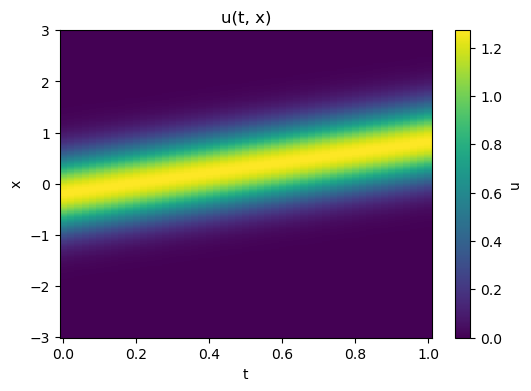

In [86]:

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")   # match sol[t,x]
print(T.shape, X.shape, np.array(output_tr[:,:,0]).shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, np.array(output_tr[:,:,0]), shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("u(t, x)")
plt.colorbar(label="u")
plt.show()


In [87]:
tt,xx = jnp.meshgrid(t_grid, x_grid)
tx_grid = jnp.concatenate([tt.flatten()[:,None], xx.flatten()[:,None]], axis=1) #xt_grid[:,1] is x, xt_grid[:,0] is t
print("tx_grid is of shape (n, coord) = ",tx_grid.shape)

tx_grid is of shape (n, coord) =  (13056, 2)


## initializing model, loss_fn

In [88]:
u_dim = 2 # in this case, two 
y_dim = 2 # (t,x)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_bases] 
trunk_arch  = [y_dim, 40, 40, num_bases] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (len(t_grid), num_bases, output_tr.shape[2])) # now A_model is a 3-tensor -- indexed as t, branch, n. as opposed to one matrix for entire xt domain
print("A_model is shape (t, num_bases, num_samples) = ", A_model.shape)

model = trunk_model, A_model

def loss_fn(model):
    trunk_model, A_model = model
    T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid) # trunk model matrix. output of model given input entire [x_grid, t_grid]
    print(T_MAT.shape, A_model.shape)
    pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples
    # pred_y[i,:,:] = T_mat[i,:,:] @ A_model[i,:,:], T_mat @ A_model for each individual time, analogous to vanilla case
    return jnp.mean((output_tr - pred_y) ** 2)/jnp.mean(output_tr ** 2) + eps # rel mean squared error



A_model is shape (t, num_bases, num_samples) =  (51, 10, 256)


In [89]:
%%time
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []
# standard eqx training step
@eqx.filter_jit
def train_step(model, opt_state):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

s_time = time.time()
start_time = time.time()
for step in range(num_trunk_epochs):
    model, opt_state, loss = train_step(model, opt_state)
    loss_hist.append(float(loss)) # store as list
    if step % 10 == 0: # new carriage print, avoid tqdm for memory
        end_time = time.time()
        print(f"\rAdam step {step}: loss={float(loss):.3e}, {end_time-start_time:.2f}s", end="", flush=True)
        start_time = time.time()
e_time = time.time()
print(f"\nfinal adam loss: {loss:.3e}, total time: {e_time-s_time:.2f}s\n")

## LBFGS disabled for now. rebuild to match adam
# opt = optax.lbfgs()

# for step in range(num_LBFGS_epochs):
#     model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
#     loss_hist.append(float(loss))
#     if step % 1000 == 0:
#         print(f"LBFGS step {step}: loss={float(loss):.3e}")


(51, 256, 10) (51, 10, 256)
Adam step 29990: loss=2.907e-04, 0.10s
final adam loss: 5.726e-04, total time: 271.26s

CPU times: user 1min 24s, sys: 24.7 s, total: 1min 49s
Wall time: 4min 31s


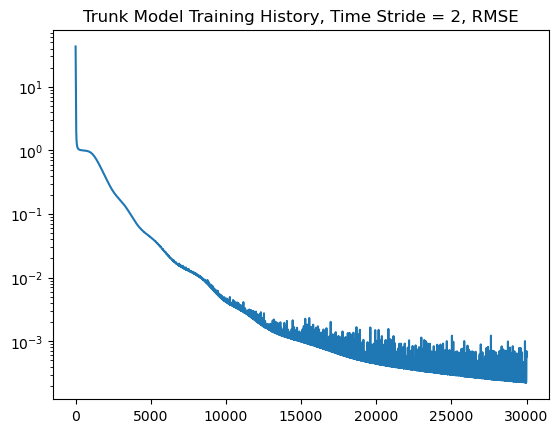

In [90]:
plt.plot(loss_hist)
plt.title(f"Trunk Model Training History, Time Stride = {t_stride}, RMSE")
plt.yscale('log')

## QR Factorizations at Time Data

In [91]:
# SAME LOGIC AS ABOVE - T_MAT is trunk matrix output of entire [x_grid, t_grid]
trunk_model, A_model = model
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
print("T_MAT is shape (t,x,n) = ", T_MAT.shape)

T_MAT is shape (t,x,n) =  (51, 256, 10)


(51, 256) (51, 256) (51, 256)


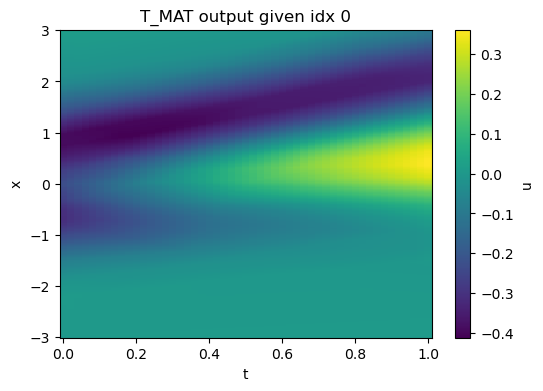

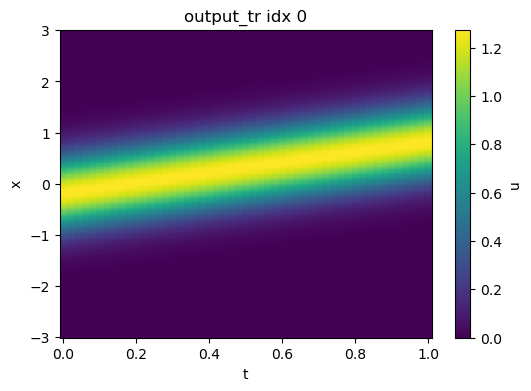

In [92]:

print(T.shape, X.shape, T_MAT[:,:,5].shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, T_MAT[:,:,5], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("T_MAT output given idx 0")
plt.colorbar(label="u")
plt.show()

plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, output_tr[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("output_tr idx 0")
plt.colorbar(label="u")
plt.show()



In [93]:
# for index i of t_grid (subsampled here every 2)
for i in range(len(t_grid)):
    # take QR of T_MAT[i,:,:]
    Q,R,P = scipy.linalg.qr(T_MAT[i], mode = 'economic', pivoting = True)
    # Q = scipy.linalg.lstsq(R.T,T_MAT_dense[i].T)[0].T
    if i == 0:
        Q_MAT = Q[jnp.newaxis, :, :] # make the 3 tensor
        R_MAT = R[jnp.newaxis,:, :]
    else:
        Q_MAT = jnp.concatenate([Q_MAT, Q[jnp.newaxis, :, :]], axis = 0) # stack Q_MAT in first dimension
        R_MAT = jnp.concatenate([R_MAT, R[jnp.newaxis, :, :]], axis = 0)
    
print(f"Q_MAT is of shape (t,x,n) = {Q_MAT.shape}")
print(f"R_MAT is of shape {R_MAT.shape}")
print("shapes agree?", Q_MAT.shape == T_MAT.shape)

Q_MAT is of shape (t,x,n) = (51, 256, 10)
R_MAT is of shape (51, 10, 10)
shapes agree? True


## svd of data and solns

In [94]:
sv_tol = 1e-4 # what we are considering as singular
# output_tr is t,x,n
data_rank_hist = []

for i,t in enumerate(t_grid):
    data_at_t = output_tr[i, :, :]
    _, data_S, _ = scipy.linalg.svd(data_at_t)
    rank_at_t = jnp.sum(data_S > sv_tol)
    data_rank_hist.append(rank_at_t)

Text(0, 0.5, 'rank')

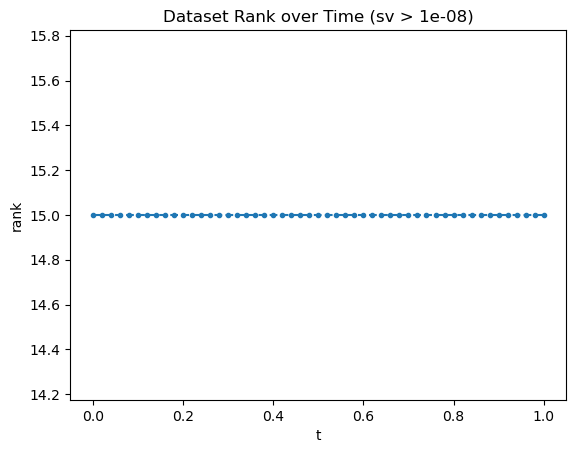

In [95]:
plt.plot(t_grid, data_rank_hist, '.--')
plt.title(f"Dataset Rank over Time (sv > {eps})")
plt.xlabel("t")
plt.ylabel("rank")


In [96]:
# plt.plot(t_grid, soln_rank_hist)
# plt.title(f"Rank over Time of Q[1] (sv > {eps})")
# plt.xlabel("t")
# plt.ylabel("rank")

In [97]:
_,R_last = scipy.linalg.qr(T_MAT[-1], mode = 'economic')

## 3d renders

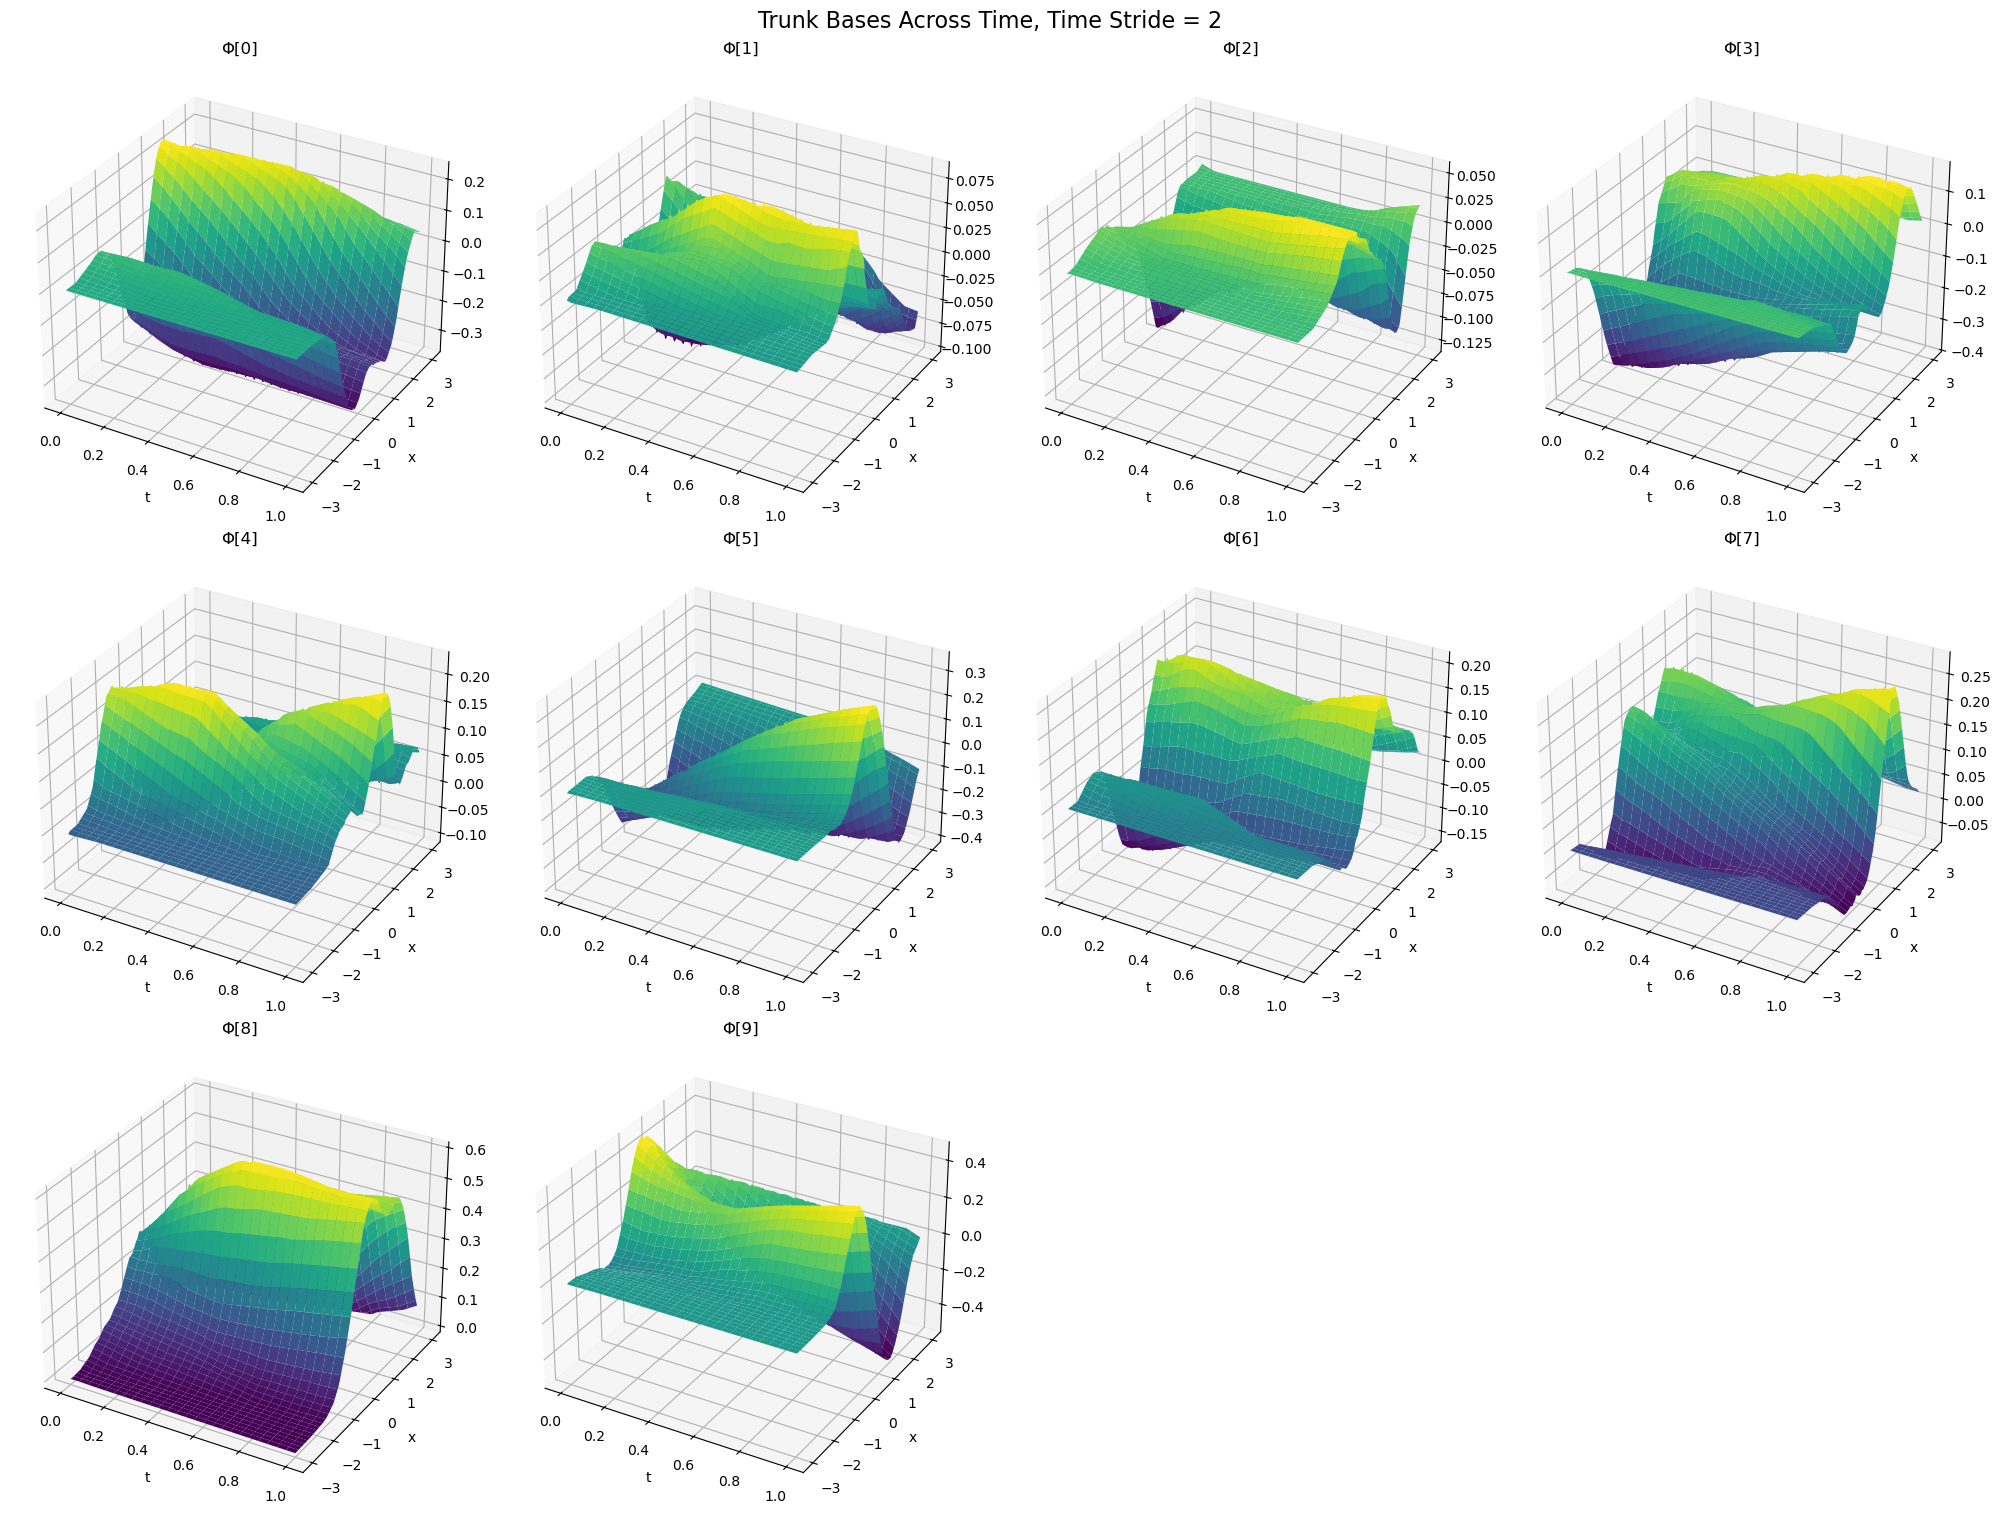

In [98]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid, x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        B_k = T_MAT[:,:,k]
        im = ax.plot_surface(T,X,B_k, cmap = 'viridis')
        ax.set_title(f"Φ[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Trunk Bases Across Time, Time Stride = {t_stride}", fontsize=16)
plt.show()

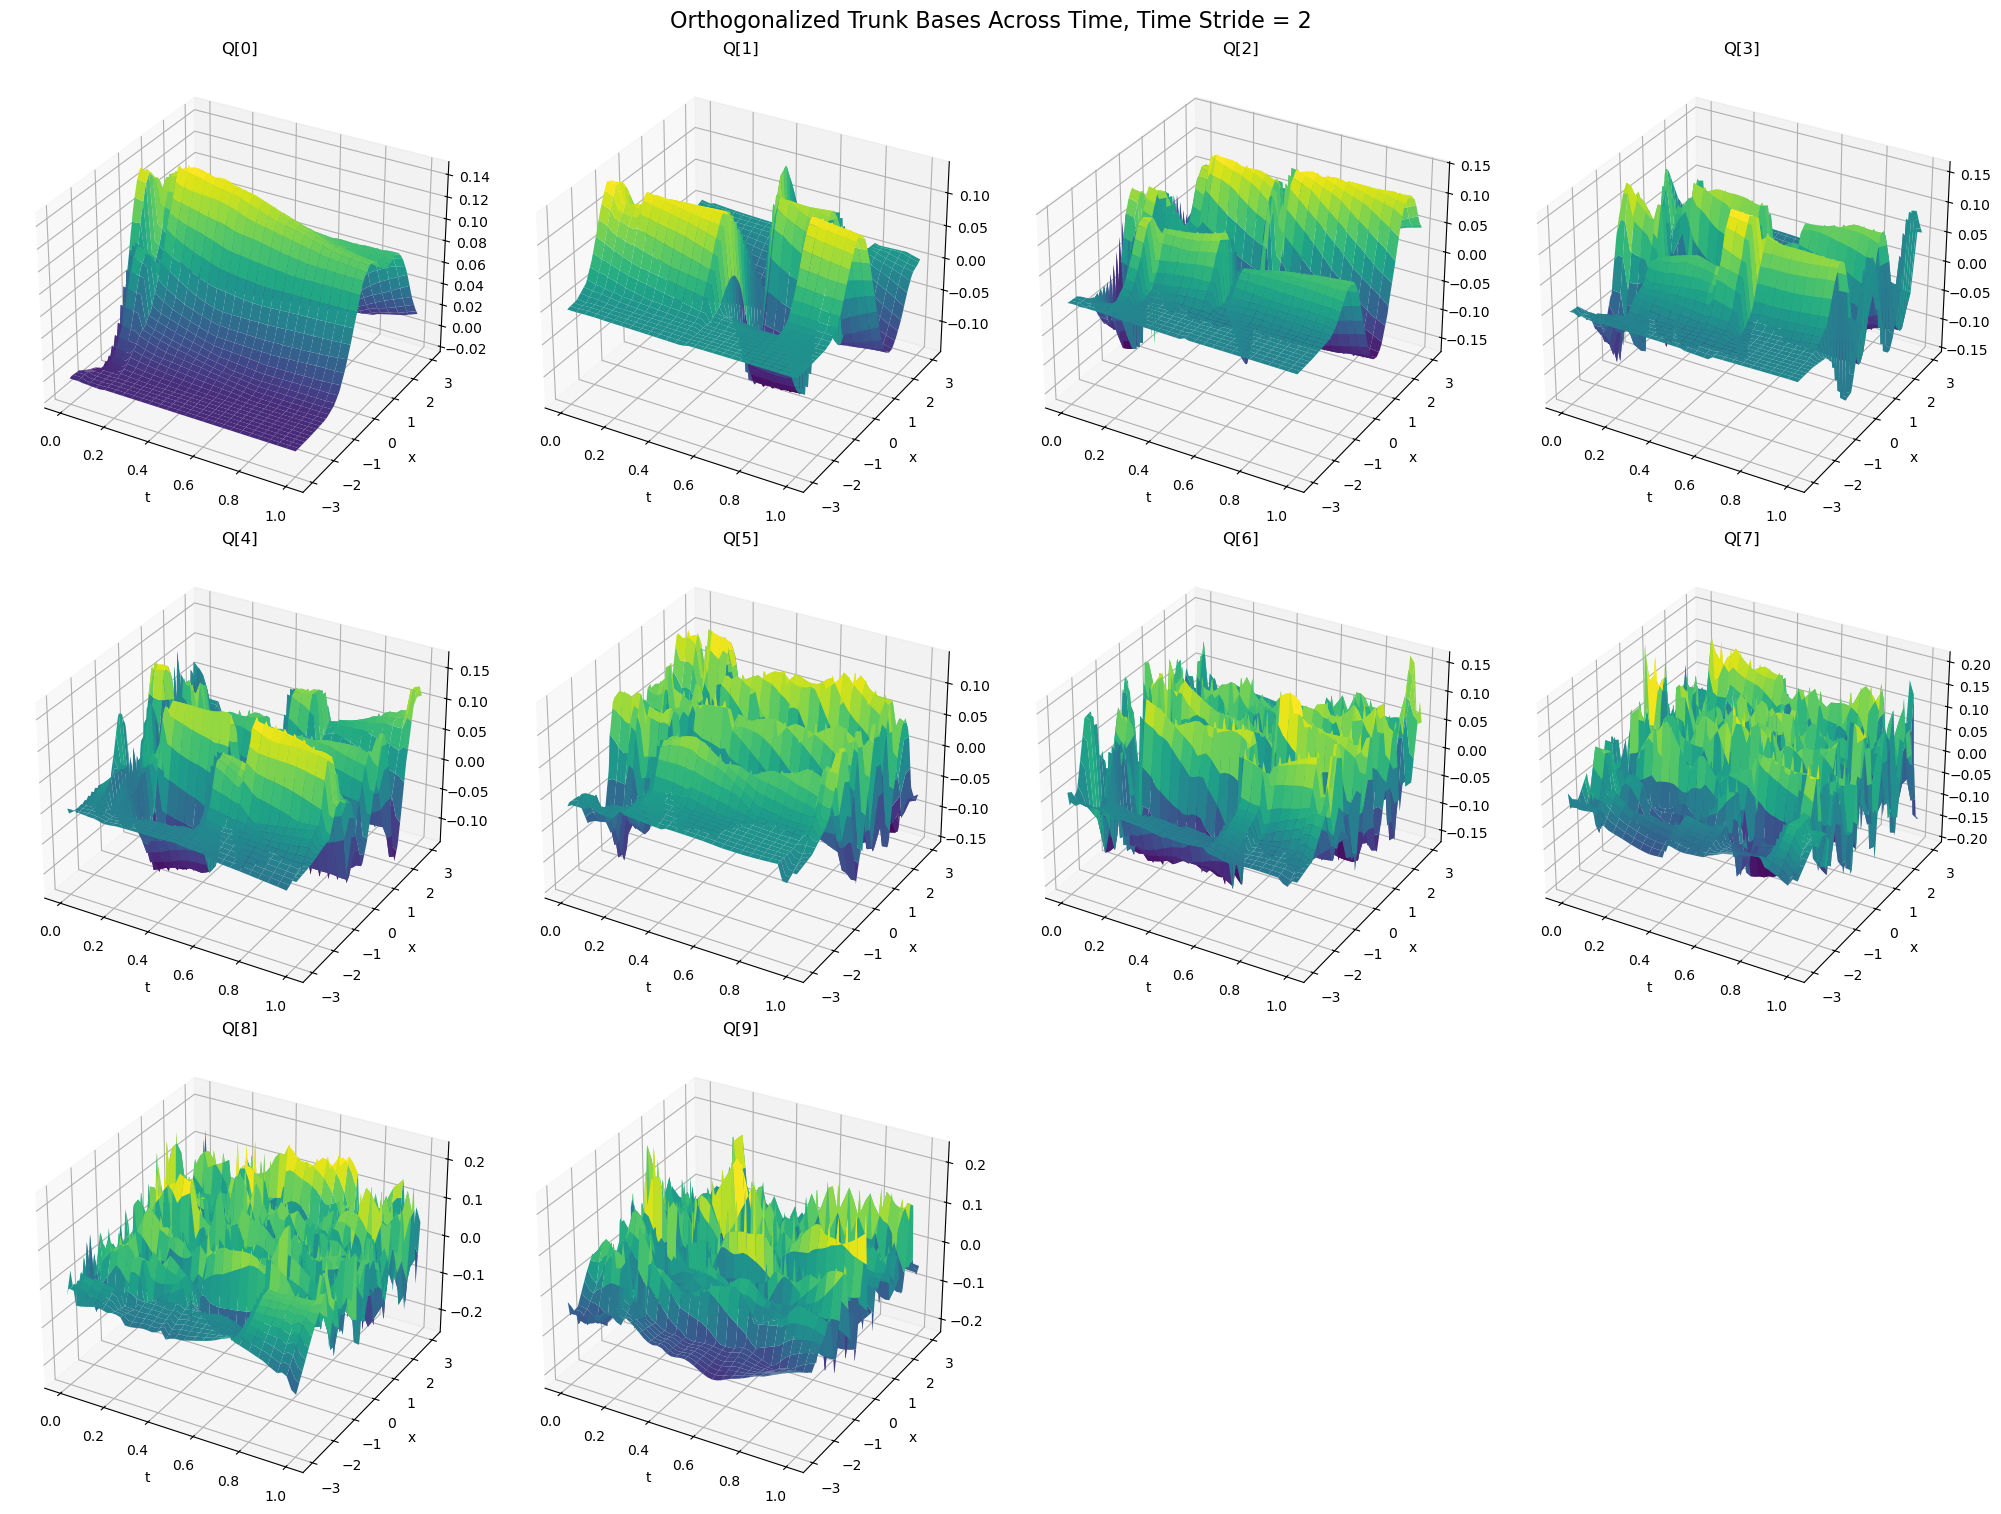

In [99]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))
T, X = np.meshgrid(t_grid, x_grid, indexing="ij") 

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), constrained_layout=True, subplot_kw = dict(projection = '3d'))

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:,:,k]
        im = ax.plot_surface(T,X,Q_k, cmap = 'viridis')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(f"Orthogonalized Trunk Bases Across Time, Time Stride = {t_stride}", fontsize=16)
plt.show()

(51, 256) (51, 256) (51, 256)


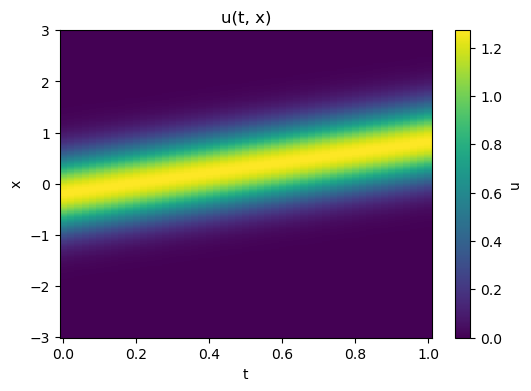

In [100]:

print(T.shape, X.shape, output_tr[:,:,0].shape)
plt.figure(figsize=(6,4))
plt.pcolormesh(T, X, output_tr[:,:,0], shading='auto', cmap='viridis')
plt.xlabel("t")
plt.ylabel("x")
plt.title("u(t, x)")
plt.colorbar(label="u")
plt.show()


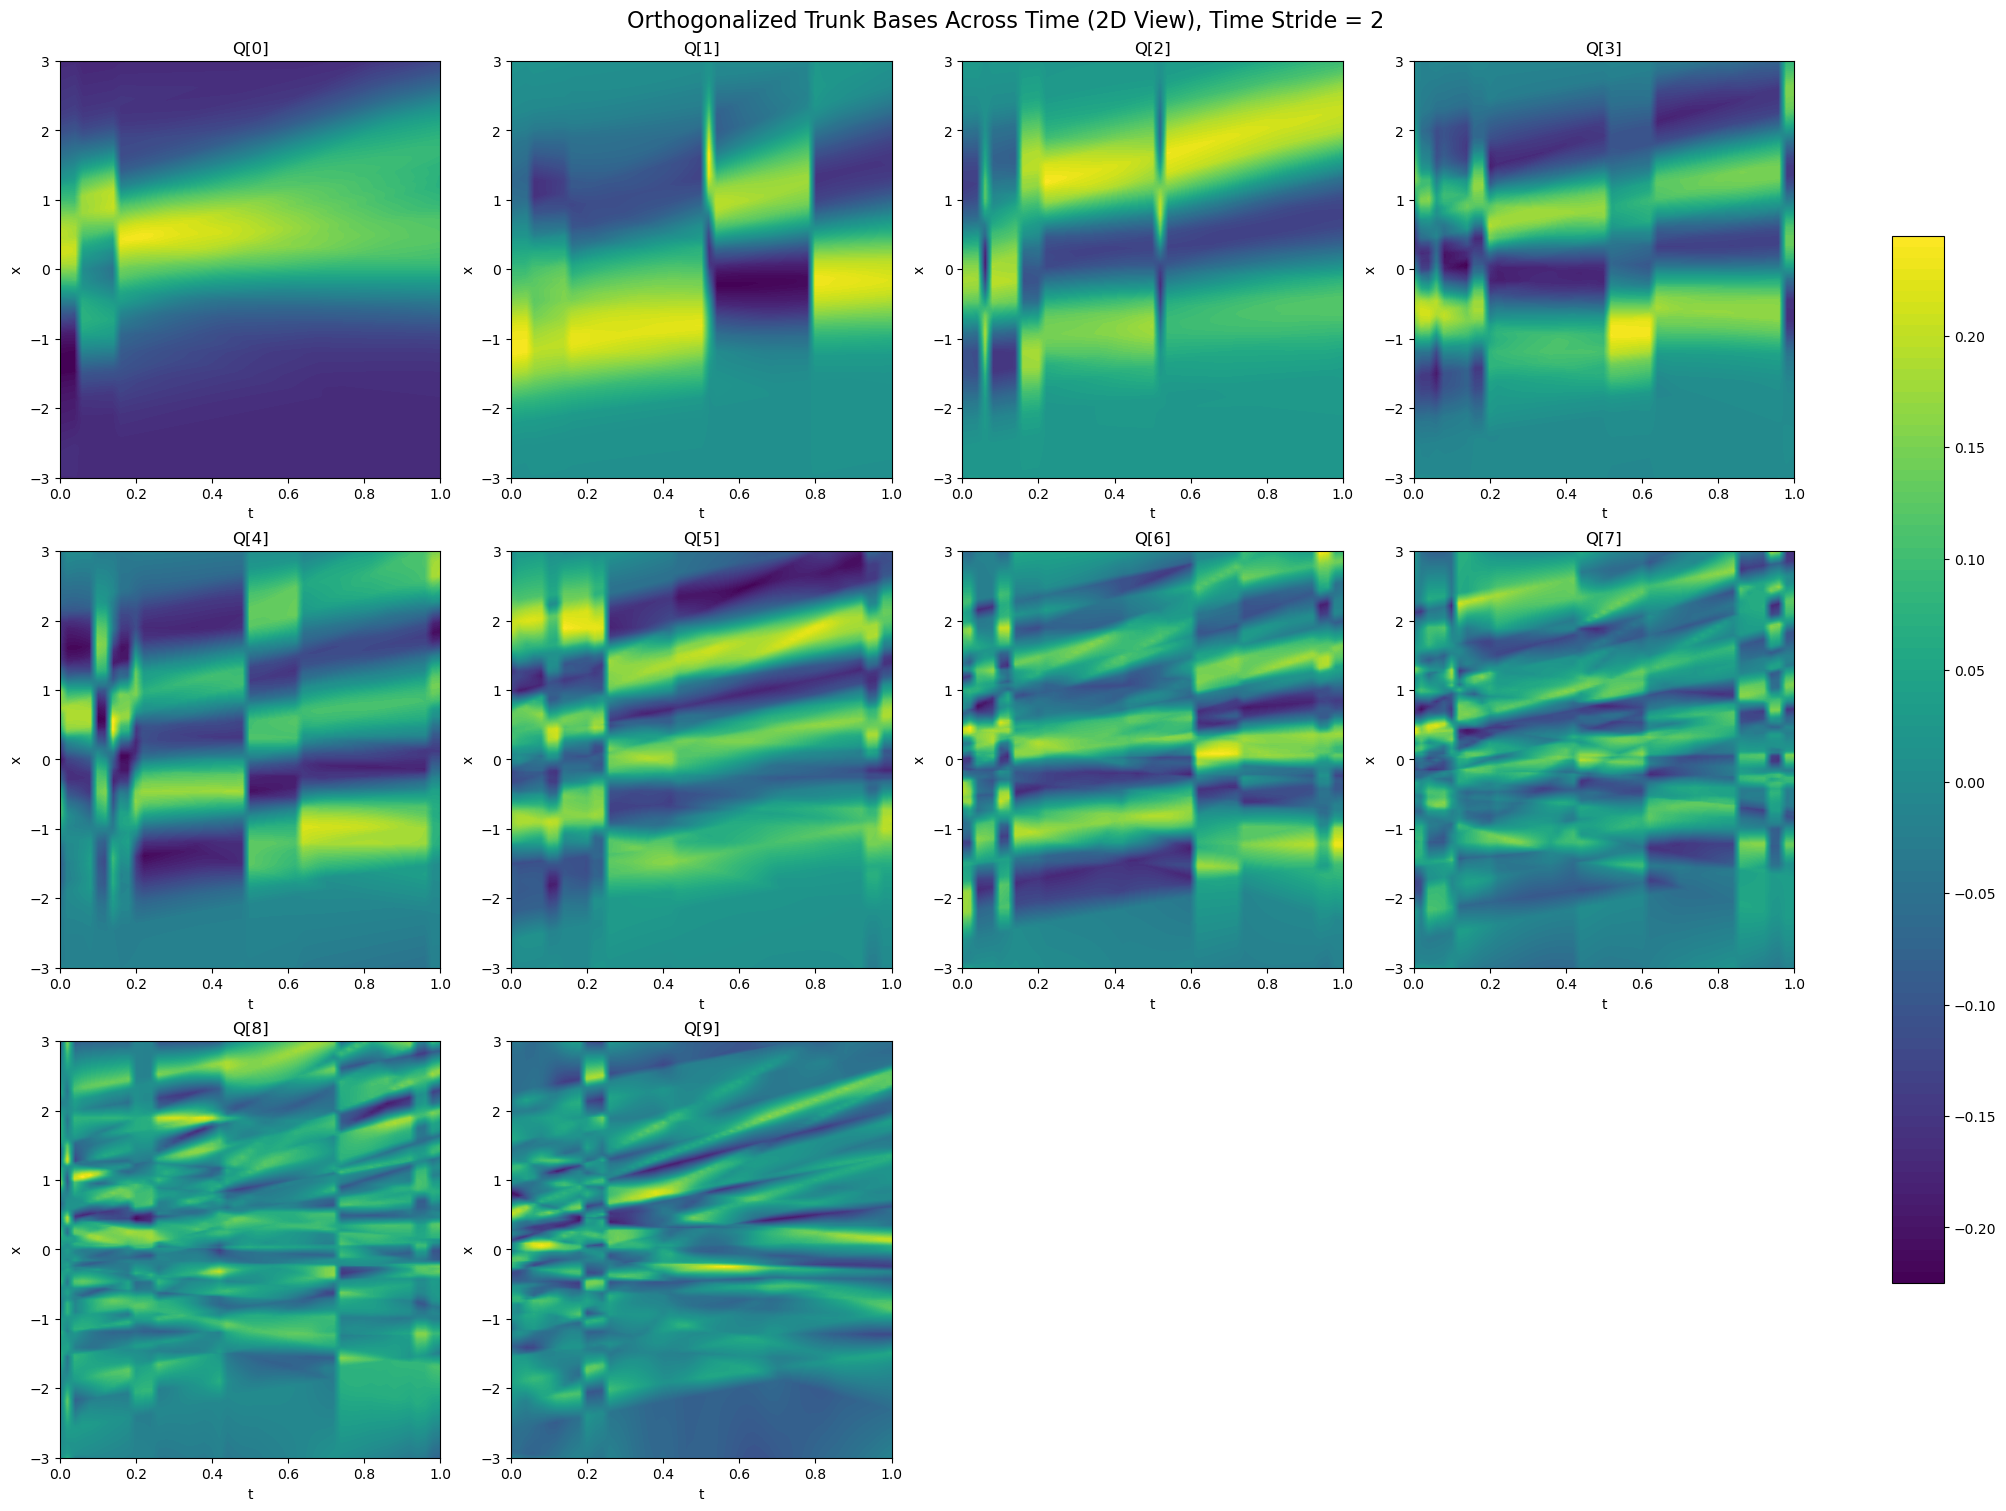

In [101]:
ncols = 4
nrows = int(np.ceil(num_bases / ncols))

T, X = np.meshgrid(t_grid, x_grid, indexing="ij")

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5 * ncols, 5 * nrows),
    constrained_layout=True
)

axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_bases:
        Q_k = Q_MAT[:, :, k]

        # 2D top-down plot
        im = ax.contourf(T, X, Q_k, levels=100, cmap='viridis')

        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("t")
        ax.set_ylabel("x")
    else:
        ax.axis("off")

fig.suptitle(
    f"Orthogonalized Trunk Bases Across Time (2D View), Time Stride = {t_stride}",
    fontsize=16
)

# attach a single colorbar for the whole figure
cbar = fig.colorbar(im, ax=axes.tolist(), shrink=0.75)

plt.show()


In [102]:
sv_tol = 1e-4 # what we are considering as singular
# output_tr is t,x,n
basis_rank_hist = []
B_k = np.array(T_MAT[:,:,k])
print(B_k.shape)
for i,t in enumerate(t_grid):
    basis_at_t = B_k[i,:].reshape(1,-1)
    _, basis_S, _ = scipy.linalg.svd(basis_at_t)
    basis_rank_hist.append(rank_at_t)

(51, 256)


Text(0, 0.5, 'rank')

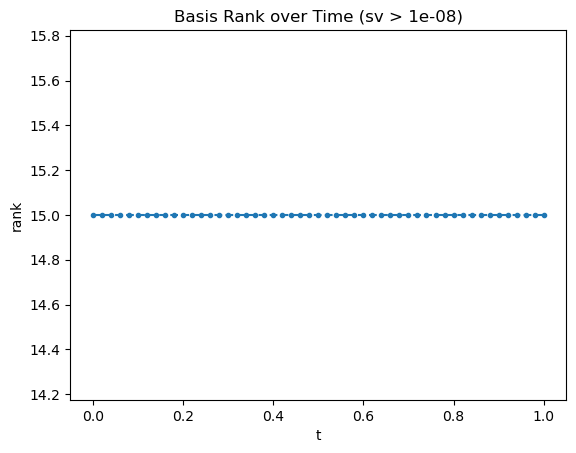

In [103]:
plt.plot(t_grid, basis_rank_hist, '.--')
plt.title(f"Basis Rank over Time (sv > {eps})")
plt.xlabel("t")
plt.ylabel("rank")


In [104]:
sv_tol = 1e-4 # what we are considering as singular
# output_tr is t,x,n
Q_rank_hist = []
Q_k = np.array(Q_MAT[:,:,k])
print(Q_k.shape)
for i,t in enumerate(t_grid):
    basis_at_t = Q_k[i,:].reshape(1,-1)
    _, basis_S, _ = scipy.linalg.svd(basis_at_t)
    Q_rank_hist.append(rank_at_t)

(51, 256)


Text(0, 0.5, 'rank')

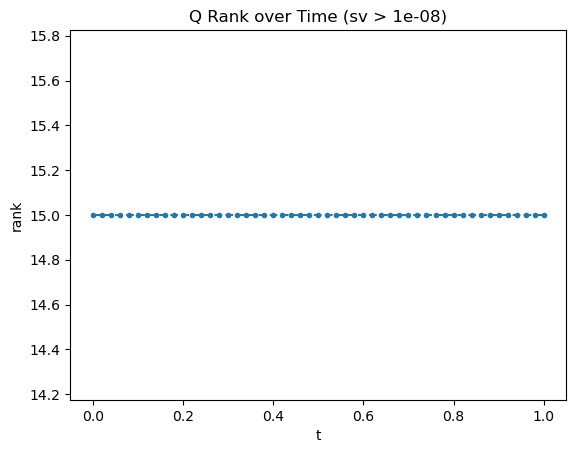

In [105]:
plt.plot(t_grid, Q_rank_hist, '.--')
plt.title(f"Q Rank over Time (sv > {eps})")
plt.xlabel("t")
plt.ylabel("rank")


Text(0, 0.5, 'cond(T_MAT[t])')

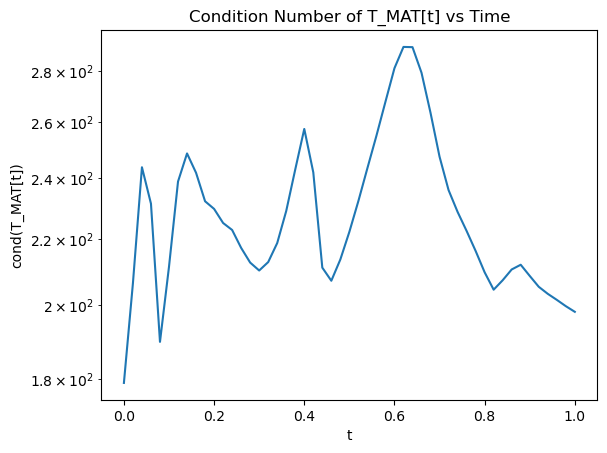

In [106]:
cond_hist = []

for i in range(len(t_grid)):
    U, S, Vh = scipy.linalg.svd(T_MAT[i,:,:], compute_uv=True)
    cond_hist.append(S[0] / S[-1])

plt.plot(t_grid, cond_hist)
plt.yscale('log')
plt.title("Condition Number of T_MAT[t] vs Time")
plt.xlabel("t")
plt.ylabel("cond(T_MAT[t])")


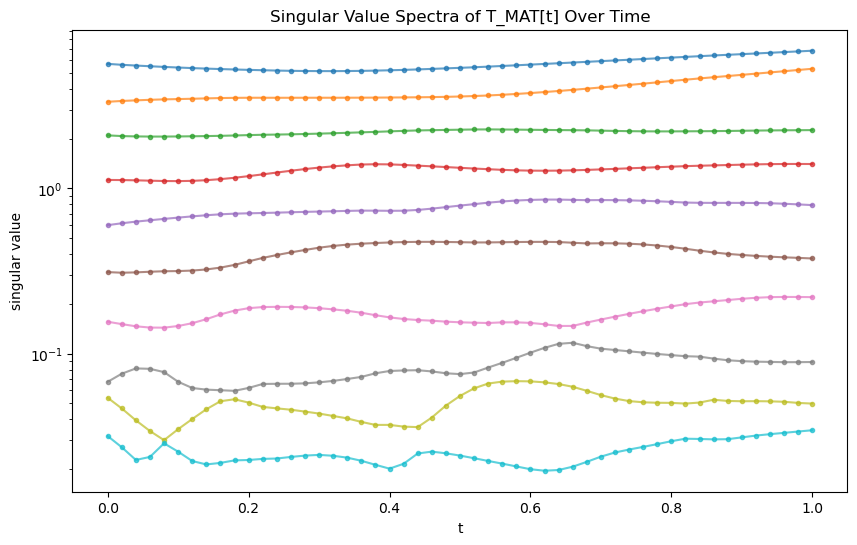

In [107]:
num_times = T_MAT.shape[0]

# compute SVD spectra at all times
sv_list = []
for i in range(num_times):
    _, S, _ = scipy.linalg.svd(np.array(T_MAT[i]), full_matrices=False)
    sv_list.append(S)

sv_array = np.vstack(sv_list)   # shape (t, num_bases)

plt.figure(figsize=(10,6))

for k in range(sv_array.shape[1]):
    plt.plot(t_grid, sv_array[:, k], '.-', alpha=0.7)

plt.yscale('log')
plt.xlabel("t")
plt.ylabel("singular value")
plt.title("Singular Value Spectra of T_MAT[t] Over Time")
#plt.grid(True, which='both', ls='--', alpha=0.3)

plt.show()

## .gif renders

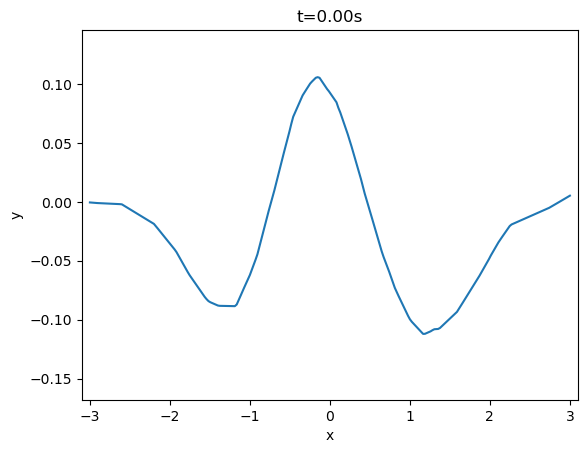

In [108]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation

basis_idx = 2
fig, ax = plt.subplots()
line2 = ax.plot(x_grid,Q_MAT[0,:,basis_idx])[0]
vmin, vmax = jnp.min(Q_MAT[:,:,basis_idx]), jnp.max(Q_MAT[:,:,basis_idx])
ax.set(xlim=[-3.1, 3.1], ylim=[vmin, vmax], xlabel='x', ylabel='y')
# ax.legend()

def update(frame):
    line2.set_xdata(x_grid)
    line2.set_ydata(Q_MAT[frame,:,basis_idx])
    # update the title:
    ax.set_title(f't={t_grid[frame]:.2f}s')
    return line2

ani = animation.FuncAnimation(fig=fig, func=update, frames=len(t_grid) -1 , interval=50)
ani.save(filename=f"DON_basis_{basis_idx}.gif", writer="pillow")

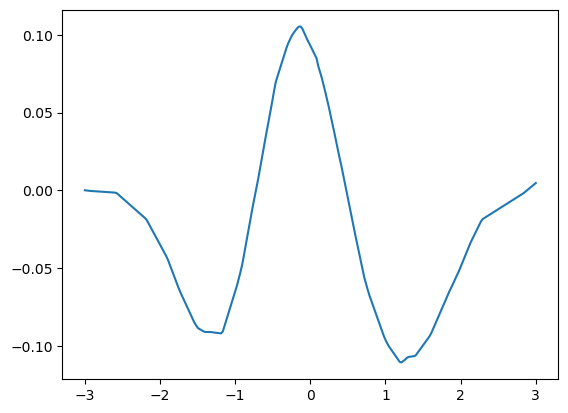

In [109]:
plt.plot(x_grid,Q_MAT[1,:,2])[0]

In [110]:
T_MAT = jax.vmap(lambda t: jax.vmap(lambda x: trunk_model(jnp.stack([x,t])))(x_grid))(t_grid)
pred_y = jnp.einsum("txN, tNk -> txk",T_MAT, A_model) # einsum is a tensor contraction. keep t index (time) and at each t index, do (x,N) times (N,k) -> (x,k). N = num_fxns, k = num_samples

